# DPU example: Yolo_v3

This notebooks shows how to run a YOLO network based application for object detection. The application, as well as the DPU IP, is pulled from the official [Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
For more information, please refer to the [Xilinx Vitis AI page](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

In this notebook we will be using the DNNDK **Python API** to run the DPU tasks.

## 1. Prepare the overlay
We will download the overlay onto the board. Then we will load the 
corresponding DPU model.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_tf_yolov3.elf")

## 2. Constants and helper functions 

You can view all of the helper functions in [DNNDK yolo example](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/tf_yolov3_voc.py). 
The helper functions released along with Vitis AI cover pre-processing of 
the images, so they can be normalized and resized to be compatible with 
the DPU model. These functions are included in our `pynq_dpu` package.

In [2]:
import numpy as np
import random
import cv2
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

import serial
import math 
import threading
import time

### Constants

Yolo V2 and V3 predict offsets from a predetermined set of boxes with 
particular height-width ratios; those predetermined set of boxes are the 
anchor boxes. We will use the predefined [anchors](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/model_data/yolo_anchors.txt).

In [3]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)
do_display = 1;

We will use the `get_class()` function in `tf_yolov3_voc` module to
get class names from predefined [class names](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/image/voc_classes.txt).

In [4]:
classes_path = "img/voc_classes.txt"
class_names = get_class(classes_path)

Depending on the number of classes, we will define a unique color for each
class.

In [5]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

We can define some DPU-related parameters, such as DPU kernel name and
input/output node names.

In [6]:
KERNEL_CONV="tf_yolov3"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_59_convolution"
CONV_OUTPUT_NODE2="conv2d_67_convolution"
CONV_OUTPUT_NODE3="conv2d_75_convolution"

### Drawing bounding boxes
We now define a custom function that draws the bounding boxes around 
the identified objects after we have the classification results.

In [7]:
def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

### Predicting classes
We need to define a function that evaluates the scores and makes predictions
based on the provided class names.

In [8]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

### Prepare the robot environment


In [9]:
foot_step_y =  [279.784161172141,279.186908630917,278.277002300741,277.115005759996,275.754049819188,274.240538017160,272.614797512661,270.911678712097,269.161106838920,267.388588516087,265.615676300516,263.860393977703,262.137625295807,260.459468691776,258.835560437576,257.273368512539,255.778459388321,254.354739796168,253.004675432211,251.729488445440,250.529335445055,249.403467658971,248.350374773650,247.367913887052,246.453424911499,245.603833671643,244.815743854573,244.085518884410,243.409354712554,242.783344437067,242.203535590490,241.665980864702,241.166782974233,240.702134295633,240.268351860143,239.861908219853,239.479458653788,239.117865129785,238.774217390597,238.445851488256,238.130366049206,237.825636514050,237.529827559732,237.241403878501,236.959139456928,236.682125469386,236.409776873649,236.141837771345,235.878385572837,235.619833984375,235.366934815005,235.120778581331,234.882793869785,234.654745398101,234.438730700184,234.237175341054,234.052826550887,233.888745149043,233.748295610053,233.635134103552,233.553194318798,233.506670861300,233.499999983990,233.537837387820,233.625032796419,233.766600976033,233.967688835097,234.233538197038,234.569443794824,234.980705986075,235.472577632684,236.050204528515,236.718558692392,237.482363770785,238.346011714935,239.313469810093,240.388177039675,241.572928663905,242.869747780455,244.279742513152,245.802947343574,247.438146958587,249.182680834279,251.032226612511,252.980560150118,255.019289931825,257.137563335859,259.321742025226,261.555043507194,263.817145658071,266.083750749154,268.326105232242,270.510471248619,272.597545513279,274.541820895751,276.290885669441,277.784655032326,278.954529112336,279.722471260182,280,280.157035805566,280.313935001052,280.470524379144,280.626649404310,280.782155999279,280.936890697097,281.090700792585,281.243434493039,281.394941068032,281.545070998166,281.693676122632,281.840609785429,281.985726980093,282.128884492803,282.269941043716,282.408757426397,282.545196645194,282.679124050441,282.810407471340,282.938917346399,283.064526851294,283.187112024028,283.306551887270,283.422728567744,283.535527412556,283.644837102345,283.750549761139,283.852561062818,283.950770334074,284.045080653759,284.135398948539,284.221636084743,284.303706956333,284.381530568888,284.455030119539,284.524133072763,284.588771231970,284.648880806803,284.704402476090,284.755281446392,284.801467506071,284.842915074851,284.879583248794,284.911435840669,284.938441415667,284.960573322422,284.977809719312,284.990133596013,284.997532790291,285.000000000000,284.997532790291,284.990133596013,284.977809719312,284.960573322422,284.938441415667,284.911435840669,284.879583248794,284.842915074851,284.801467506071,284.755281446392,284.704402476090,284.648880806803,284.588771231970,284.524133072763,284.455030119539,284.381530568888,284.303706956333,284.221636084743,284.135398948539,284.045080653759,283.950770334074,283.852561062818,283.750549761139,283.644837102345,283.535527412556,283.422728567744,283.306551887270,283.187112024028,283.064526851294,282.938917346399,282.810407471340,282.679124050441,282.545196645194,282.408757426397,282.269941043716,282.128884492803,281.985726980093,281.840609785429,281.693676122632,281.545070998166,281.394941068032,281.243434493039,281.090700792585,280.936890697097,280.782155999279,280.626649404310,280.470524379144,280.313935001052,280.157035805566,279.999981633974];
foot_step_x = [64.7962241881123,66.9281948440417,68.9047458853030,70.7336632089232,72.4214871275340,73.9734081466605,75.3932398834638,76.6834545548556,77.8452679930586,78.8787625824203,79.7830378556315,80.5563797434742,81.1964406427908,81.7004235554845,82.0652645599333,82.2878088081130,82.3649760998204,82.2939128724922,82.0721281639968,81.6976117592065,81.1689333218330,80.4853218436418,79.6467252163808,78.6538501502127,77.5081830286980,76.2119926070127,74.7683157296147,73.1809274684994,71.4542972659614,69.5935328088481,67.6043134670304,65.4928151996159,63.2656288705983,60.9296739234989,58.4921093443607,55.9602437964515,53.3414467404231,50.6430622626238,47.8723272239227,45.0362952138752,42.1417676524195,39.1952332255899,36.2028166749700,33.1702377847724,30.1027812274658,27.0052777406881,23.8820969166770,20.7371516924551,17.5739144363544,14.3954443359375,11.2044256057212,8.00321585206032,4.79390375878943,1.57837509240965,-1.64161412862989,-4.86435859807750,-8.08812024531625,-11.3110418570447,-14.5310594324856,-17.7458149855232,-20.9525715656347,-24.1481323068966,-27.3287653293420,-30.4901363081892,-33.6272504926440,-36.7344058958352,-39.8051592897264,-42.8323065223615,-45.8078785283573,-48.7231542260251,-51.5686912847656,-54.3343755033598,-57.0094892624317,-59.5827992016640,-62.0426629233360,-64.3771541374586,-66.5742052392998,-68.6217658465369,-70.5079753197783,-72.2213467459584,-73.7509592783283,-75.0866550986851,-76.2192365963852,-77.1406586438718,-77.8442100892641,-78.3246777823629,-78.5784856006467,-78.6038000458836,-78.4005930393470,-77.9706515537933,-77.3175226828730,-76.4463816630621,-75.3638092291274,-74.0774635011926,-72.5956303693243,-70.9266350598978,-69.0780962365581,-67.0560026071199,-64.8635905760431,-62.5000000000000,-61.2500000000000,-60,-58.7500000000000,-57.5000000000000,-56.2500000000000,-55,-53.7500000000000,-52.5000000000000,-51.2500000000000,-50,-48.7500000000000,-47.5000000000000,-46.2500000000000,-45,-43.7500000000000,-42.5000000000000,-41.2500000000000,-40,-38.7500000000000,-37.5000000000000,-36.2500000000000,-35,-33.7500000000000,-32.5000000000000,-31.2500000000000,-30,-28.7500000000000,-27.5000000000000,-26.2500000000000,-25,-23.7500000000000,-22.5000000000000,-21.2500000000000,-20.0000000000000,-18.7500000000000,-17.5000000000000,-16.2500000000000,-15,-13.7500000000000,-12.5000000000000,-11.2500000000000,-10.0000000000000,-8.75000000000000,-7.50000000000000,-6.25000000000000,-5.00000000000000,-3.75000000000000,-2.50000000000000,-1.25000000000000,0,1.25000000000000,2.50000000000000,3.75000000000000,5.00000000000000,6.25000000000001,7.50000000000001,8.75000000000000,10.0000000000000,11.2500000000000,12.5000000000000,13.7500000000000,15,16.2500000000000,17.5000000000000,18.7500000000000,20.0000000000000,21.2500000000000,22.5000000000000,23.7500000000000,25.0000000000000,26.2500000000000,27.5000000000000,28.7500000000000,30,31.2500000000000,32.5000000000000,33.7500000000000,35,36.2500000000000,37.5000000000000,38.7500000000000,40.0000000000000,41.2500000000000,42.5000000000000,43.7500000000000,45,46.2500000000000,47.5000000000000,48.7500000000000,50,51.2500000000000,52.5000000000000,53.7500000000000,55.0000000000000,56.2500000000000,57.5000000000000,58.7500000000000,60,61.2500000000000,62.5000000000000];


In [10]:
#Function to calculate roll, hip and knee angles from the x,y,z coords of the foot wrt the hip.
def xyztoang(x,y,z,yoffh,hu,hl):
    dyz=np.sqrt(y**2+z**2)
    lyz=np.sqrt(dyz**2-yoffh**2)
    gamma_yz=-np.arctan(y/z)
    gamma_h_offset=-np.arctan(-yoffh/lyz)
    gamma=gamma_yz-gamma_h_offset

    lxzp=np.sqrt(lyz**2+x**2)
    n=(lxzp**2-hl**2-hu**2)/(2*hu)
    beta=-np.arccos(n/hl)

    alfa_xzp=-np.arctan(x/lyz)
    alfa_off=np.arccos((hu+n)/lxzp)
    alfa=alfa_xzp+alfa_off
    if any( np.isnan([gamma,alfa,beta])):
        print(x,y,z,yoffh,hu,hl)
    return [alfa,beta,gamma]

In [11]:
def pose_control(rpy_r,rpy_p,rpy_y,pos_x, pos_y, pos_z):
    # 定义结构参数
    b = 120;
    w = 120;
    l = 250;
    # 定义目标位姿
    #pos = np.mat([0.0,  0.0,  0.3 ]).T # 目标位置向量
    #	rpy = np.array([0.0,  0.0,  0.0]) * math.pi / 180 # 欧拉角，化为弧度值
    # 将欧拉角转换为旋转矩阵
    #	R, P, Y = rpy[0], rpy[1], rpy[2]
    pos = np.mat([pos_x,  pos_y,  pos_z ]).T

    R = rpy_r;
    P = rpy_p;
    Y = rpy_y;

    rotx = np.mat([[ 1,       0,            0          ],
         [ 0,       math.cos(R), -math.sin(R)],
         [ 0,       math.sin(R),  math.cos(R)]])
    roty = np.mat([[ math.cos(P),  0,      -math.sin(P)],
         [ 0,            1,       0          ],
         [ math.sin(P),  0,       math.cos(P)]]) 
    rotz = np.mat([[ math.cos(Y), -math.sin(Y),  0     ],
         [ math.sin(Y),  math.cos(Y),  0     ],
         [ 0,            0,            1     ]])
    rot_mat = rotx * roty * rotz
    # 结构参数
    body_struc = np.mat([[ l / 2,  b / 2,  0],
               [ l / 2, -b / 2,  0],
               [-l / 2,  b / 2,  0],
               [-l / 2, -b / 2,  0]]).T
    footpoint_struc = np.mat([[ l / 2,  w / 2,  0],
                    [ l / 2, -w / 2,  0],
                    [-l / 2,  w / 2,  0],
                    [-l / 2, -w / 2,  0]]).T
    # 计算单腿末端位置向量AB
    AB = np.mat(np.zeros((3, 4)))
    leg_pose = np.mat(np.zeros((3, 4)))
    position_pos = np.mat(np.zeros((3, 4)))
    for i in range(4):
        leg_pose[:, i] = - pos - rot_mat * body_struc[:, i] + footpoint_struc[:, i]
  
    return leg_pose


In [12]:
def serial_walk_control(rpy_r,rpy_p,rpy_y,pos_x, pos_y, pos_z,t,foot_step_x,foot_step_y, setp_count, setp_depth):
    position_zero=[ 1500,   1500,    1500,
                    1500,   1500,    1500,
                    1500,   1500,    1500,
                    1500,   1500,    1500];
    z_gain    = 0.2 * setp_depth#250;
    x_gaim    = 0.4 * setp_depth#400;
    time_step = 1 #50;
    leg_pose = np.mat(np.zeros((3, 4)))
    j = setp_count;
    length_lut = len(foot_step_x);

    leg_pose = pose_control(rpy_r,rpy_p,rpy_y,pos_x, pos_y, pos_z);

    lf_x  = leg_pose[0,0] - x_gaim*(foot_step_x[setp_count%length_lut]);
    lf_y  = leg_pose[1,0];
    lf_z  = leg_pose[2,0] + z_gain*(foot_step_y[setp_count%length_lut]-230);
    lb_x  = leg_pose[0,1] - x_gaim*(foot_step_x[(setp_count + (length_lut>>1))%length_lut]);
    lb_y  = leg_pose[1,1];
    lb_z  = leg_pose[2,1] + z_gain*(foot_step_y[(setp_count + (length_lut>>1))%length_lut]-230);
    rf_x  = leg_pose[0,2] - x_gaim*(foot_step_x[(setp_count + (length_lut>>1))%length_lut]);
    rf_y  = leg_pose[1,2];
    rf_z  = leg_pose[2,2] + z_gain*(foot_step_y[(setp_count + (length_lut>>1))%length_lut]-230);
    rb_x  = leg_pose[0,3] - x_gaim*(foot_step_x[setp_count%length_lut]);
    rb_y  = leg_pose[1,3];
    rb_z  = leg_pose[2,3] + z_gain*(foot_step_y[setp_count%length_lut]-230);

    [lf_alfa,lf_beta,lf_gamma]=xyztoang(lf_x,lf_y,lf_z,0,105,130);
    [lb_alfa,lb_beta,lb_gamma]=xyztoang(lb_x,lb_y,lb_z,0,105,130);
    [rf_alfa,rf_beta,rf_gamma]=xyztoang(rf_x,rf_y,rf_z,0,105,130);
    [rb_alfa,rb_beta,rb_gamma]=xyztoang(rb_x,rb_y,rb_z,0,105,130);

    #position_pos = fix(position_angle/pi*180/135*1000);
    const = 1000/3.1416*180/135;
    position_angle =        [-rf_beta  * const , -rf_alfa * const , rf_gamma * const ,
                              lf_beta  * const ,  lf_alfa * const , lf_gamma * const ,
                             -rb_beta  * const , -rb_alfa * const ,-rb_gamma * const ,
                              lb_beta  * const ,  lb_alfa * const ,-lb_gamma * const ];

    position_pos = np.trunc(position_angle);
    pose_print = position_pos + position_zero;

    for i in range(12): #=1:12
        position  = np.int(position_zero[i] + position_pos[i]);
        send_text = "#"+str(i+1)+"P"+str(position)+"T"+str(t)+"!";
        result=ser.write(send_text.encode("UTF-8"))
        #print("send_text",send_text,position)
        time.sleep(0.002)
    return position_pos

In [13]:
def walk_frount(direction):
    setp_depth = 0;
    setp_count = 0;
    i = 0;
    while i < 600:
        i = i + 20;
        
        if i < 200:
            if setp_depth < 1:
                setp_depth = setp_depth + 0.1
            else:
                setp_depth = 1                
        elif i > 400:
            if setp_depth > 0:
                setp_depth = setp_depth - 0.1
            else:
                setp_depth = 0

        length_lut = len(foot_step_x)
        setp_count = setp_count + 20 ;
        setp_count = int(setp_count%(len(foot_step_x)*2-1))

        #print("setp_count:", setp_count%length_lut, (setp_count + length_lut>>1)%length_lut,(setp_count + (length_lut>>1))%length_lut)

        if direction == 1: #go frount
            serial_walk_control(0.0,0.0,0,10,0,-150,40,foot_step_x,foot_step_y, setp_count, setp_depth);
        elif direction == 0: #go back
            serial_walk_control(0.0,0.0,0,10,0,-150,40,foot_step_x,foot_step_y, setp_count-199, setp_depth);
        time.sleep(0.04)
    return 0

capture isOpened


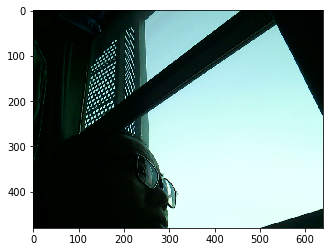

In [14]:
capture = cv2.VideoCapture(0)
# 打开自带的摄像头
if capture.isOpened():
    # 以下两步设置显示屏的宽高
    print('capture isOpened')
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    read_code,image = capture.read()
    if do_display == 1 :
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        print('chose not to dispaly image')
    #capture.release()
else:
    print('capture open fail!!!')
        

The following cell will normalize the input picture size.

In [15]:
image_size = image.shape[:2]
image_data = np.array(pre_process(image, (416, 416)), dtype=np.float32)

## 3. Run application

We create DPU kernel and task.

In [16]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

Now we execute the DPU task to classify an input picture.

In [17]:
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
n2cube.dpuSetInputTensorInHWCFP32(
    task, CONV_INPUT_NODE, image_data, input_len)

n2cube.dpuRunTask(task)

conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                               conv_sbbox_size)
conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                               conv_mbbox_size)
conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                               conv_lbbox_size)
conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

yolo_outputs = [conv_out1, conv_out2, conv_out3]    

We can call the `evaluate()` function defined previously now. Depending on
how many objects can be identified in the picture, the function returns
a list of bounding box coordinates, a list of probability scores, and a list
of class indexes.

In [18]:
boxes, scores, classes = evaluate(yolo_outputs, image_size, 
                                  class_names, anchors)

Once we have all the bounding boxes, classes, and scores, we can feed them to
the `draw_boxes()` function to draw the bounding boxes over each recognized object.

first image runing OK!


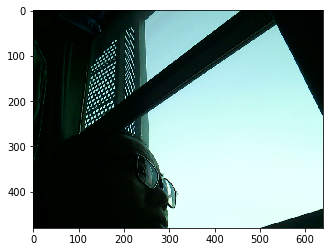

In [19]:
if do_display == 1 :
    _ = draw_boxes(image, boxes, scores, classes)
else:
    print('chose not to dispaly image')
print('first image runing OK!')

In [20]:
### open Serial
portx = "/dev/ttyUSB1"
bps = 115200
timex = 5

ser=serial.Serial(portx,bps,timeout=timex)

print("serial isOpened!!")


serial isOpened!!


[[ 275.39178467  278.03015137  460.15032959  586.19628906]] [ 0.99736941] [7]
walk back


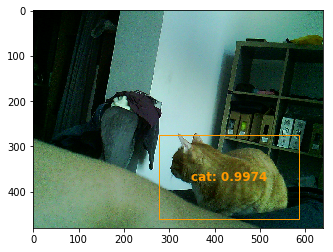

In [43]:
# run in streaming mode
i = 0;
while i < 1:
    i = i + 1;    
    read_code,image = capture.read()
    image_size = image.shape[:2]
    image_data = np.array(pre_process(image, (416, 416)), dtype=np.float32)
    
    input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
    n2cube.dpuSetInputTensorInHWCFP32(
        task, CONV_INPUT_NODE, image_data, input_len)

    n2cube.dpuRunTask(task)

    conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
    conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                                   conv_sbbox_size)
    conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

    conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
    conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                                   conv_mbbox_size)
    conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

    conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
    conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                                   conv_lbbox_size)
    conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

    yolo_outputs = [conv_out1, conv_out2, conv_out3]  

    boxes, scores, classes = evaluate(yolo_outputs, image_size, 
                                  class_names, anchors)
    print(boxes, scores, classes)
    
    if do_display == 1 :
        #_, ax = plt.subplots(1)
        #_ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        _ = draw_boxes(image, boxes, scores, classes)
    else:
        print('chose not to dispaly image')
    
    if 7 in classes: # == 7 :#cat
        #walk back
        walk_frount(0)
        print('walk back')
    elif 14 in classes :# == 14: #person
        #walk frount 
        walk_frount(1)
        print('walk frount')
    else:
        print('Stand still')
        
    

In [20]:
capture.release()
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

0

Copyright (C) 2020 Xilinx, Inc.